In [1]:
import numpy
import matplotlib
import cv2
import os

import tensorflow

In [2]:
path = "../input/dynamic-sign-language-gestures-01/all"

In [3]:
image_size = 64, 64

def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    
    if hasFrames:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, image_size)

    return [hasFrames, image]

In [4]:
x_train = []
y_train = []

# videos_list = sorted(os.listdir(path))
videos_list = sorted(os.listdir(path))[:500]
new_list = []

for xyz in range(10):
    mno = xyz*50
    for index in range(mno, mno+20):
        new_list.append(videos_list[index])
        
frame_rate = 0.2
count = 0

for video in new_list:
    count += 1
    print(count)
    
    vidcap = cv2.VideoCapture(path + '/' + video)
    
    sec = 0
    X_mini = []
    success, frame = getFrame(sec)
    
    while success:
        X_mini.append(frame)
        sec = sec + frame_rate
        sec = round(sec, 2)
        success, frame = getFrame(sec)
    
    length = len(X_mini)
    
    if length < 10:
        while length != 10:
            X_mini.insert(0, numpy.zeros((64, 64)))
            length += 1
    elif length > 10:
        while length != 10:
            X_mini.pop(0)
            length -= 1
    
    image = numpy.vstack(X_mini)
    x_train.append(image)
    y_train.append(int(video[:3]))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


In [5]:
x_test = []
y_test = []

# videos_list = sorted(os.listdir(path))
videos_list = sorted(os.listdir(path))[:500]
new_list = []

for xyz in range(10):
    mno = xyz*50 + 30
    for index in range(mno, mno+10):
        new_list.append(videos_list[index])
        
frame_rate = 0.2
count = 0

for video in new_list:
    count += 1
    print(count)
    
    vidcap = cv2.VideoCapture(path + '/' + video)
    
    sec = 0
    X_mini = []
    success, frame = getFrame(sec)
    
    while success:
        X_mini.append(frame)
        sec = sec + frame_rate
        sec = round(sec, 2)
        success, frame = getFrame(sec)
    
    length = len(X_mini)
    
    if length < 10:
        while length != 10:
            X_mini.insert(0, numpy.zeros((64, 64)))
            length += 1
    elif length > 10:
        while length != 10:
            X_mini.pop(0)
            length -= 1
    
    image = numpy.vstack(X_mini)
    x_test.append(image)
    y_test.append(int(video[:3]))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [6]:
x_train = numpy.array(x_train)
y_train = numpy.array(y_train)

x_test = numpy.array(x_test)
y_test = numpy.array(y_test)

In [7]:
from __future__ import absolute_import
from __future__ import print_function

import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import random
from keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Activation,AveragePooling2D
from keras import backend as K

In [8]:
num_classes = 10
epochs = 20
 
def euclid_dis(vects):
  x,y = vects
  sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))
 
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)
 
def contrastive_loss(y_true, y_pred):
    y_true=tf.dtypes.cast(y_true, tf.float64)
    y_pred=tf.dtypes.cast(y_pred, tf.float64)
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [9]:
def create_pairs(x, digit_indices):
  pairs = []
  labels = []
   
  n=min([len(digit_indices[d]) for d in range(num_classes)]) -1
   
  for d in range(num_classes):
    for i in range(n):
      z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
      pairs += [[x[z1], x[z2]]]
      inc = random.randrange(1, num_classes)
      dn = (d + inc) % num_classes
      z1, z2 = digit_indices[d][i], digit_indices[dn][i]
      pairs += [[x[z1], x[z2]]]
      labels += [1,0]
  return np.array(pairs), np.array(labels)

In [10]:
def create_base_net(input_shape):
   
  input = Input(shape = input_shape)
  x = Conv2D(4, (5,5), activation = 'relu')(input)
  x = AveragePooling2D(pool_size = (2,2))(x)
  x = Conv2D(16, (5,5), activation = 'relu')(x)
  x = AveragePooling2D(pool_size = (2,2))(x)
  x = Conv2D(16, (5,5), activation = 'relu')(x)
  x = AveragePooling2D(pool_size = (2,2))(x)
  x = Flatten()(x)
  x = Dense(10, activation = 'relu')(x)
  model = Model(input, x)
  model.summary()
  return model
 
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)
 
 
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [11]:
x_train = x_train.reshape(x_train.shape[0], 640, 64,1)
x_test = x_test.reshape(x_test.shape[0], 640, 64, 1)
input_shape = (1, 640, 64)
print(x_train.shape)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
x_train /= 255
x_test /= 255
 
input_shape = x_train.shape[1:]
input_shape = (640, 64, 1)

(200, 640, 64, 1)


In [12]:
digit_indices = [np.where(y_train == i)[0] for i in range(1, num_classes+1)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)
 
digit_indices = [np.where(y_test == i)[0] for i in range(1, num_classes+1)]
te_pairs, te_y = create_pairs(x_test, digit_indices)
 
# network definition
base_network = create_base_net(input_shape)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 640, 64, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 636, 60, 4)        104       
_________________________________________________________________
average_pooling2d (AveragePo (None, 318, 30, 4)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 314, 26, 16)       1616      
_________________________________________________________________
average_pooling2d_1 (Average (None, 157, 13, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 153, 9, 16)        6416      
_________________________________________________________________
average_pooling2d_2 (Average (None, 76, 4, 16)         0     

In [13]:
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
 
processed_a = base_network(input_a)
processed_b = base_network(input_b)
 
distance = Lambda(euclid_dis,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])
 
model = Model([input_a, input_b], distance)
#train
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=64,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Epoch 1/20
6/6 [==============================] - 5s 194ms/step - loss: 0.4370 - accuracy: 0.5084 - val_loss: 0.3101 - val_accuracy: 0.6394
Epoch 2/20
6/6 [==============================] - 0s 50ms/step - loss: 0.2958 - accuracy: 0.5828 - val_loss: 0.2702 - val_accuracy: 0.5156
Epoch 3/20
6/6 [==============================] - 0s 47ms/step - loss: 0.1611 - accuracy: 0.7333 - val_loss: 0.2301 - val_accuracy: 0.7456
Epoch 4/20
6/6 [==============================] - 0s 46ms/step - loss: 0.1038 - accuracy: 0.8740 - val_loss: 0.2077 - val_accuracy: 0.8562
Epoch 5/20
6/6 [==============================] - 0s 50ms/step - loss: 0.0768 - accuracy: 0.9107 - val_loss: 0.1895 - val_accuracy: 0.7784
Epoch 6/20
6/6 [==============================] - 0s 49ms/step - loss: 0.0631 - accuracy: 0.9503 - val_loss: 0.1741 - val_accuracy: 0.8586
Epoch 7/20
6/6 [==============================] - 0s 47ms/step - loss: 0.0604 - accuracy: 0.9399 - val_loss: 0.1600 - val_accuracy: 0.8289
Epoch 8/20
6/6 [==========

In [14]:
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)
 
print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 99.21%
* Accuracy on test set: 82.78%


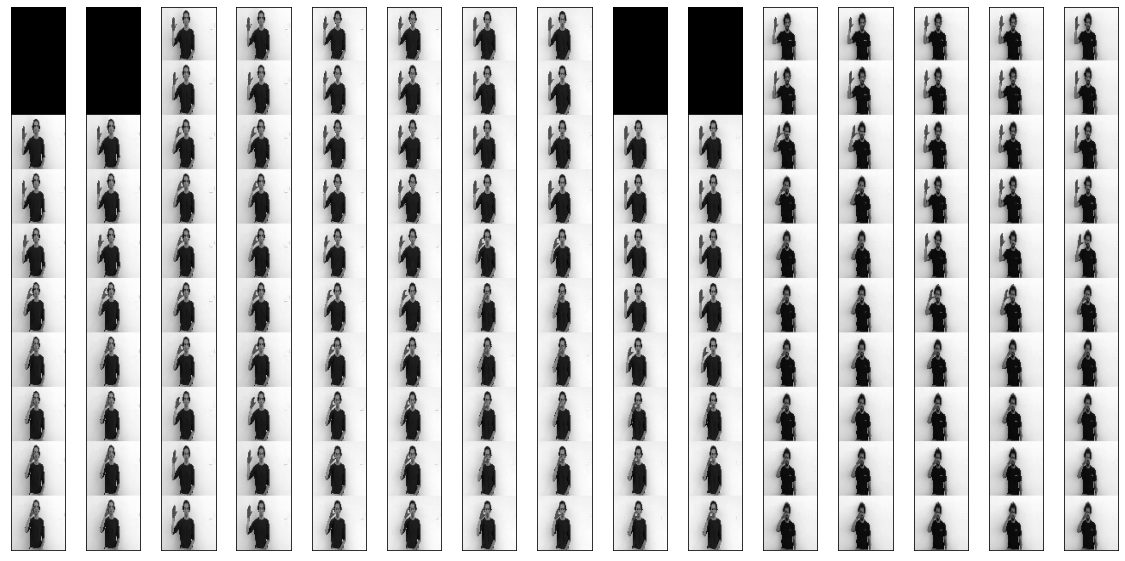

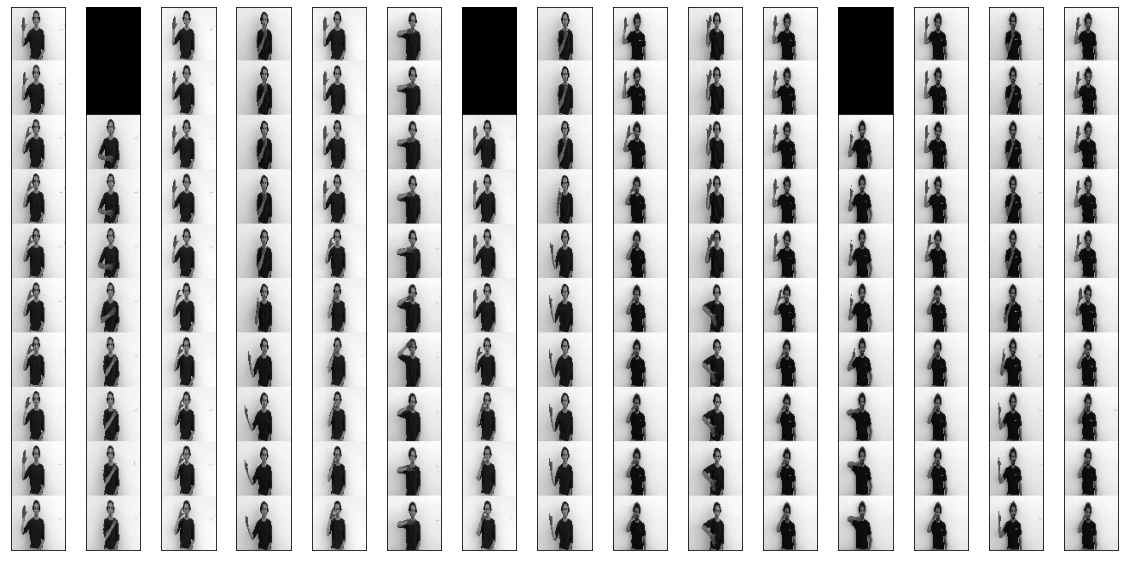

[0.13674754]
[0.46748844]
[0.27889845]
[1.4598399]
[0.12759456]
[0.8594634]
[0.21144238]
[0.5417028]
[0.7543585]
[0.7857753]
[0.15718202]
[0.9157177]
[0.15681109]
[0.34862202]
[0.27509636]


In [15]:
import matplotlib.pyplot as plt
from PIL import Image
number_of_items = 15
 
 
im = tf.keras.preprocessing.image.array_to_img(
    tr_pairs[1,0],
    data_format=None,
    scale=True,
    dtype=None
)
 
plt.figure(figsize=(20, 10))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( tr_pairs[item,0], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()
 
plt.figure(figsize=(20, 10))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( tr_pairs[item,1], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()
 
for i in range(number_of_items):
  print(y_pred[i])